matplot 출력을 이쁘게 하기 위한 설정

In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 분류 Classfication

## MNIST data set

In [2]:
from sklearn.datasets import fetch_openml

# as_frame을 해제해줘야 DataFrame이 아닌 ndarray 형태로 받아올 수 있다.
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
import numpy as np

X, y = mnist["data"], mnist["target"]
y=y.astype(np.int8)
print(X.shape) # 28*28 픽셀로된 이미지가 70,000개 존재
print(y.shape)

(70000, 784)
(70000,)


In [4]:
type(X)

numpy.ndarray

MNIST의 데이터(X)를 확인해보면 28*28 크기로된 손글씨이다.

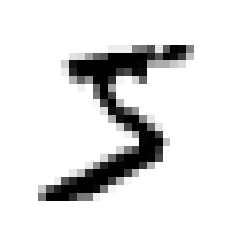

In [5]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")
plt.show()

당연히 이에 상응하는 레이블이 존재한다

In [6]:
y[0]

5

In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## 이진 분류기 (binary classfier)

숫자 5를 식별할 수 있는 분류기를 만들어보자  
데이터가 5이면 True, 이외는 False가 나온다.

In [8]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [9]:
# 경사 하강법으로 접근하기

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5) # 자료형이 np.int8이 아니면 exception이 발생한다

SGDClassifier(random_state=42)

In [10]:
# some_digit (첫번째 데이터이다. 참고로 5 맞음)
sgd_clf.predict([some_digit])

array([ True])

## 성능 측정

분류기의 평가는 회귀 모델보다 복잡하다.

### 교차 검증

In [11]:
# 걸핏보면 정확도가 93~96% 를 가지는 것으로 보인다만....
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf,X_train,y_train_5,cv=3,scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [12]:
from sklearn.base import BaseEstimator


class Never5Classifier (BaseEstimator):
    def fit(self, X, y=None):
        return self
    
    # 모든 결과를 False로 반환하는 분류기를 만들어둔다.
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

애초부터 5를 가진 데이터가 얼마 안되기에 전부다 False를 반환해도 90% 이상의 정확도를 보인다  
이처럼 불균형한 데이터셋(특정 클래스가 다른 클래스보다 많은)을 다룬다면 accuracy를 scoring을 이용X

In [13]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf,X_train,y_train_5,cv=3,scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

분류기의 성능을 평가할 때 더 좋은 방법은 잘못 분류된 횟수를 세는 것이다.  
이를 오차 행렬 (confusion matrix)을 조사한다고 한다.  
훈련 데이터를 이용하여 예상 값을 만들어내자

### 오차 행렬, 정밀도, 재현율

In [14]:
# K겹 교차 검증을 수행하긴 한다만 점수가 아닌 테스트 폴드에서 얻은 예측값을 반환한다.
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [15]:
y_train_pred

array([ True, False, False, ...,  True, False, False])

confusion matrix는 예측/실제에 대하여    
음성/음성 양성/음성  
음성/양성 양성/양성  
이런 식으로 (2,2) 행렬을 뽑아내준다.

In [16]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5,y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

양성 예측의 정확도를 TP를 진짜 양성, FP를 거짓 양성이라고 할 때,
TP/(TP+FP) 를 정밀도(precision)라고 한다.  
그리고 TP를 진짜 양성, FN을 가짜 음성(실제론 양성)이라고 할 때,  
TP/(TP+FN)을 재현율(recall)이라고 하고 양성을 확실하게 뽑아낼 비율이다.  
다른 말로는 민감도(Sensitivity), 진짜 양성 비율 (True Positive Rate, TPR) 이라고 한다.

In [17]:
from sklearn.metrics import precision_score, recall_score

print(precision_score(y_train_5,y_train_pred))
print(recall_score(y_train_5,y_train_pred))

0.8370879772350012
0.6511713705958311


F1 점수라고 해서 위 두 점수를 합친 점수가 있다. (조화 평균을 이용한다)  
정밀도와 재현율이 비슷하다면 F1 점수가 높다.  
다만 상황에 따라 정밀도 혹은 재현율이 중요할 수 있다.  
불행히도 이 둘 모두 얻기는 힘들다. 이 둘은 반비례 관계에 있어서 정밀도/재현율 트레이드오프라고 한다

In [18]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

### 정밀도/재현율 트레이드오프

SGDClassifier은 결정 함수(decision function)를 이용하여 각 샘플의 점수를 계산한다.  
이 점수가 임곗값보다 크다면 양성, 작다면 음성으로 판정하게 된다.

In [19]:
y_scores = cross_val_predict(
    sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [20]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5,y_scores)

In [21]:
def plot_precision_recall_vs_threshold(precisions,recalls,thresholds):
    plt.plot(thresholds,precisions[:-1],"b--",label="정밀도")
    plt.plot(thresholds,recalls[:-1],"g-",label="재현율")
    plt.legend(loc="center right", fontsize=16)
    plt.xlabel("Threshold", fontsize=16)
    plt.grid(True)
    plt.axis([-50000, 50000, 0, 1])

임곗값을 올리거나 내릴 때 재현율은 부드럽게 변할 수 있지만 (전체 양성중에서 양성을 뽑아내는 비율)   
정밀도의 경우, 정상 케이스가 빠지고 틀린 케이스가 남아있을 수 있어서 울퉁불퉁 해진다.  
(내가 양성이라고 판단한 것중에서 실제 양성일 확률인데 실제 양성이 줄어드니까)

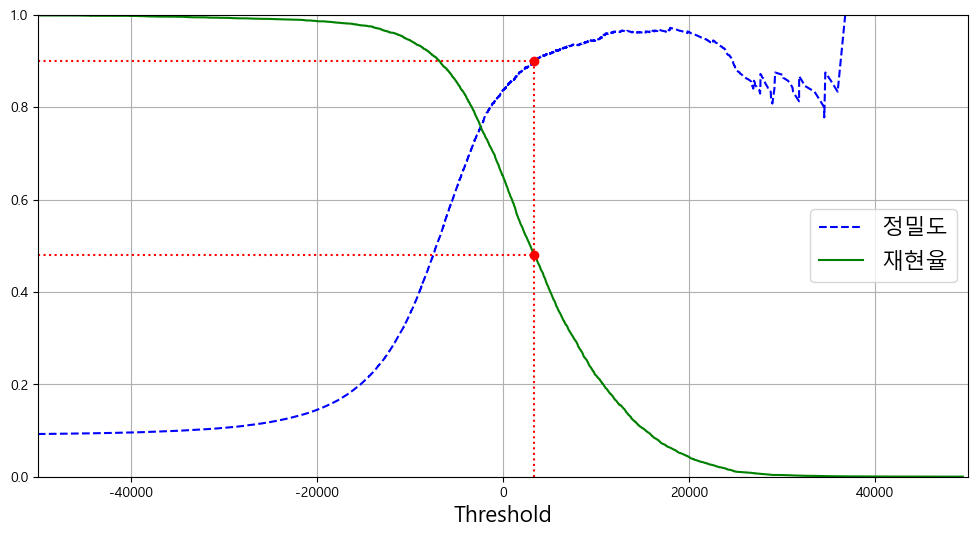

In [22]:
from matplotlib import font_manager, rc

plt.style.use('default')
plt.figure(figsize=(12,6))
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)

recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

plot_precision_recall_vs_threshold(precisions,recalls,thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")
plt.plot([threshold_90_precision], [recall_90_precision], "ro")
plt.show()

In [23]:
# 90% 이상의 정밀도를 가지는 첫번째 인덱스를 반환해준다.
# argmax는 최대값의 첫번째 인덱스를 반환하는데 저 배열에는 True,False밖에 없으니 당연

threshold_90_precision = thresholds[np.argmax(precisions>=0.90)]
threshold_90_precision

3370.0194991439557

In [24]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

print(precision_score(y_train_5,y_train_pred_90))
print(recall_score(y_train_5,y_train_pred_90))

0.9000345901072293
0.4799852425751706


### ROC 곡선

Receiver Operating Characteristic (ROC)은 이진 분류에서 쓰이는 도구이다.
거짓 양성 비율에 대한 진짜 양성 비율로 나타낼 수 있다.  

In [25]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

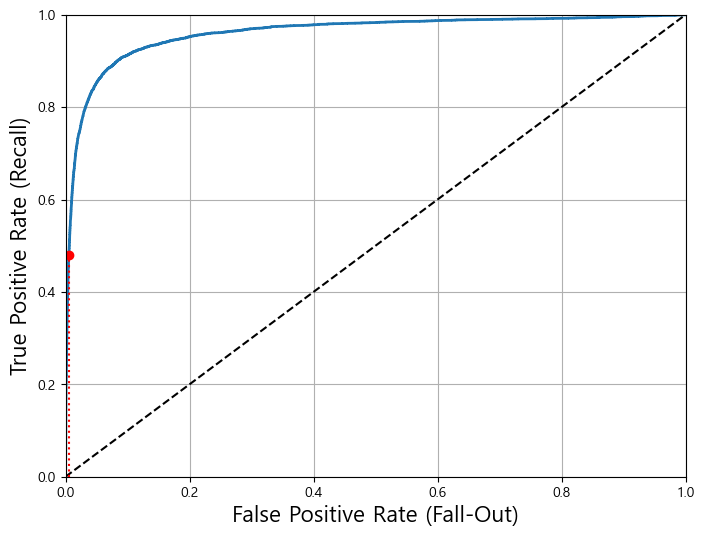

In [26]:
def plot_roc_curve(fpr,tpr,label=None):
    plt.plot(fpr,tpr,linewidth=2,label=label)
    plt.plot([0,1],[0,1],'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16)
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.show()

thresholds가 높아질수록 TPR과 FPR모두 낮아지겠지만 thresholds가 낮아질수록 둘다 증가한다.
그리고 좋은 모델일수록 TPR이 높더라도 FPR이 낮게 유지되어야한다. 따라서 곡선이 최대한 굽어야함.  
또는 곡선과 직선 사이 면적이 최대한 커야한다. (Area Under Curve, AUC)

In [27]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5,y_scores)

0.9604938554008616

물론 이 경우, 5가 별로 없는 불균형 데이터이기에 ROC곡선만 보면 좋은 모델이라고 생각할 수 있다.
이 경우 PR곡선을 써서 얼마나 더 개선될 수 있는지 따지는 것이 더 좋다.
이외의 경우 (즉 균형잡힌 데이터라면) ROC곡선이 유용하게 쓰인다.

랜덤포레스트 분류기를 사용하여 SGD와 비교해보자

In [28]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(
    forest_clf, X_train, y_train_5, cv=3, method="predict_proba")
# decision_function() 메서드 대신 predict_proba() 메서드가 있다. 
# 하나의 row가 하나의 샘플이고 각 col이 클래스가 되며 해당 클래스에 속할 확률이 담겨있다

In [29]:
y_probas_forest

array([[0.11, 0.89],
       [0.99, 0.01],
       [0.96, 0.04],
       ...,
       [0.02, 0.98],
       [0.92, 0.08],
       [0.94, 0.06]])

In [30]:
y_scores_forest = y_probas_forest[:, 1] # 점수 = 양성 클래스의 확률
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

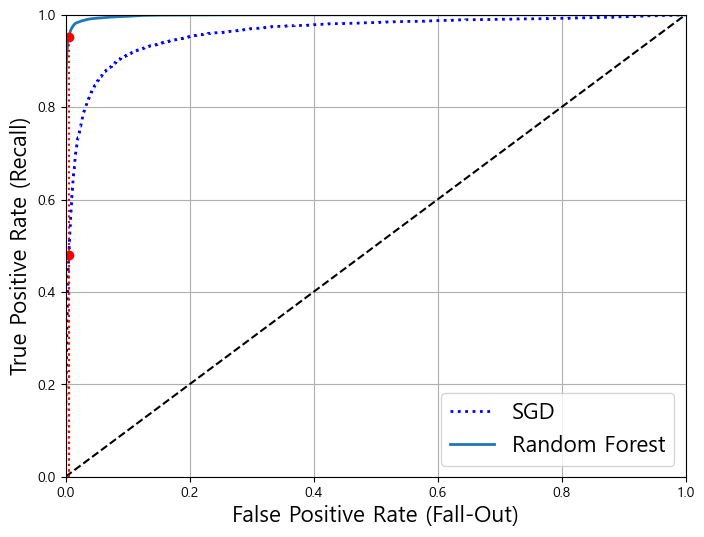

In [31]:
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, label="Random Forest")
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)

plt.show()

확실히 랜덤포레스트가 SGD보다 AUC가 더 크다.

In [32]:
print(roc_auc_score(y_train_5,y_scores_forest))
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
print(precision_score(y_train_5, y_train_pred_forest))
print(recall_score(y_train_5, y_train_pred_forest))

0.9983436731328145
0.9905083315756169
0.8662608374838591


## 다중 분류

분류해야 하는 클래스가 2개 이상인 경우, 다중 분류 (multiclass classfier)가 된다.  
클래스 별 결정 점수 중 가장 높은 것을 선택하는 방식을 OvR, OvA (One versus the Rest 또는 All)  
클래스 끼리의 조합마다 이진 분류기를 훈련 시키는 것을 OvO (One versus One) 전략이라 한다.

In [33]:
# SVC는 기본적으로 OvO 방식을 이용한다
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train,y_train)
svm_clf.predict([some_digit])

array([5], dtype=int8)

In [34]:
some_digit_scores = svm_clf.decision_function([some_digit])
print(some_digit_scores)
print(svm_clf.classes_) # 훈련할 때, 타킷 클래스의 리스트를 값으로 알아서 정렬하고 저장해줌
print(svm_clf.classes_[5])

[[ 1.72501977  2.72809088  7.2510018   8.3076379  -0.31087254  9.3132482
   1.70975103  2.76765202  6.23049537  4.84771048]]
[0 1 2 3 4 5 6 7 8 9]
5


OvR, OvO 방식을 사용하도록 강제하는 방법 (15분이나 걸린다)

In [35]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train,y_train)

OneVsRestClassifier(estimator=SVC())

In [36]:
print(ovr_clf.predict([some_digit]))
print(len(ovr_clf.estimators_))

[5]
10


SGDClassifier (또는 RandomForest를 이용하면 별도의 OvR,OvO를  적용하지 않아도됨)

In [37]:
sgd_clf.fit(X_train,y_train)
sgd_clf.predict([some_digit])

array([3], dtype=int8)

In [38]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [39]:
cross_val_score(sgd_clf, X_train, y_train,cv=3,scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [40]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf,X_train_scaled,y_train,cv=3,scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

## 에러 분석

오차 행렬을 통해 우선 제대로 분류하지 못한 경우를 살펴보기

In [41]:
y_train_pred = cross_val_predict(sgd_clf,X_train_scaled,y_train,cv=3)

In [42]:
from sklearn.metrics import plot_confusion_matrix
conf_mx = confusion_matrix(y_train,y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

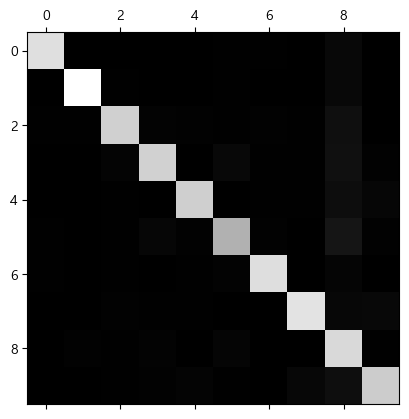

In [43]:
plt.matshow(conf_mx,cmap=plt.cm.gray)
plt.show()

row는 실제, col은 예측 class를 의미하는데 matrix자체는 꽤 맞아 보인다.  
그런데 에러율을 계산하면 8쪽에 예측 결과가 몰리는 것을 볼 수 있다.

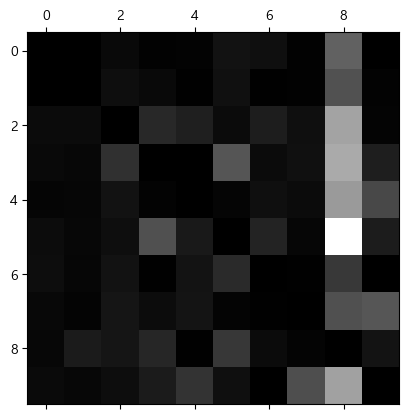

In [44]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [45]:
# 숫자 그림을 위한 추가 함수
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # n_rows = ceil(len(instances) / images_per_row) 와 동일합니다:
    n_rows = (len(instances) - 1) // images_per_row + 1

    # 필요하면 그리드 끝을 채우기 위해 빈 이미지를 추가합니다:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # 배열의 크기를 바꾸어 28×28 이미지를 담은 그리드로 구성합니다:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # 축 0(이미지 그리드의 수직축)과 2(이미지의 수직축)를 합치고 축 1과 3(두 수평축)을 합칩니다. 
    # 먼저 transpose()를 사용해 결합하려는 축을 옆으로 이동한 다음 합칩니다:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # 하나의 큰 이미지를 얻었으므로 출력하면 됩니다:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

이외에도 3과 5의 케이스를 들고와서 비교할 수 있다.<br>
실제 레이블과 예측 결과를 비교해보자

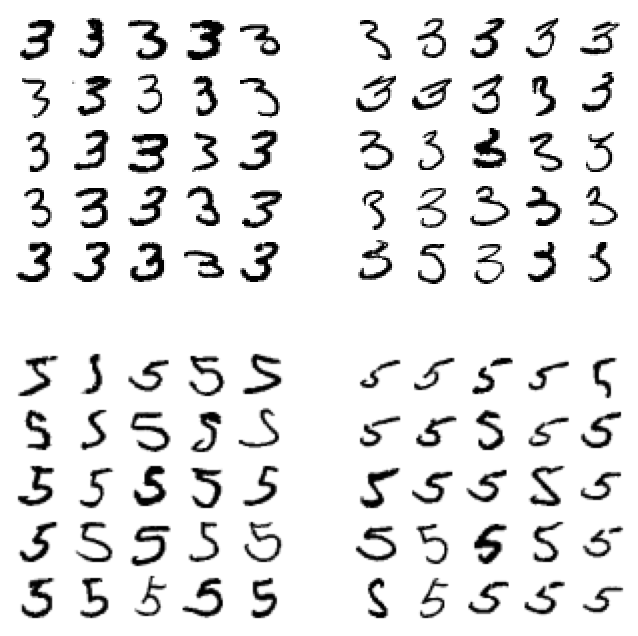

In [46]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

## 다중 레이블 분류

하나의 데이터가 지금까지는 하나의 레이블에 들어갔지만 여러 클래스를 가질 수 있다.  
이 경우, 다중 레이블 분류라고 부른다.

In [47]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd] # 7 이상이면서 홀수인 라벨을 뽑아내자

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [48]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [49]:
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_predict

y_train_knn_pred = cross_val_predict(knn_clf,X_train,y_multilabel,cv=3)
f1_score(y_multilabel,y_train_knn_pred,average="macro")

0.976410265560605

## 다중 출력 분류

다중 레이블 분류에서 하나의 레이블이 여러 클래스를 가질 수 있다면 다중 출력 분류가 된다.  
즉, 하나의 데이터가 여러 레이블을 가지고, 그 레이블의 클래스가 여러개인 경우이다.  
여기서는 노이즈를 넣어주고 원본 데이터와 맞추는 것을 예시로 든다.  
픽셀 데이터가 그 대상이 되는데, 우선 픽셀값은 0~255 사이의 값을 가지고, 하나의 이미지는 여러 픽셀을 가진다

In [50]:
noise = np.random.randint(0,100,(len(X_train),784))
X_train_mod = X_train+noise
noise = np.random.randint(0,100,(len(X_test),784))
X_test_mod = X_test+noise
y_train_mod = X_train
y_test_mod = X_test

In [51]:
knn_clf.fit(X_train_mod,y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[1]])

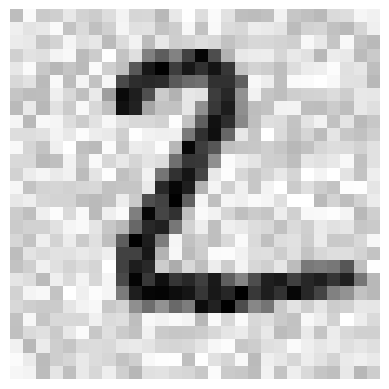

In [52]:
plot_digits([X_test_mod[1]])

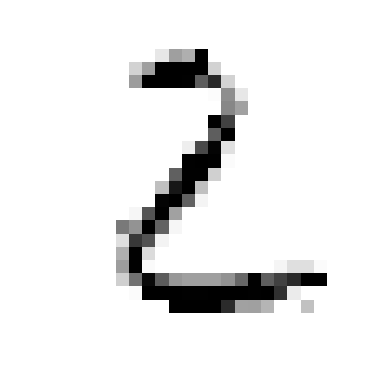

In [53]:
plot_digits(clean_digit)